# This is the code for analyzing the daily series, using sleuth outputs.
Files required to run this notebook are:

- 'daily_full_model.csv' which contains the spline coefficients for each isoform
- 'daily_time_spline.csv' which contains the basis functions for the natural cubic spline for 30 time points
- 'daily_de_genes.csv' which contains a list of DE genes from aggregated isoforms
- 't2g.csv' which is the same transcript-to-gene annotation used in the R script as a csv file
- 'daily_mtx.csv' which is the normalized (DESeq normalization) counts matrix
- 'daily_tpm.csv' which contains the TPMs for each isoform

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import r2_score

## Import files

In [2]:
full = pd.read_csv('daily_full_model.csv', index_col=0)
full.head()

,target_id,term,estimate,std_error
1,ENST00000000233.10,(Intercept),5.252784,1.236293
2,ENST00000000233.10,X1,0.066136,1.732016
3,ENST00000000233.10,X2,1.027272,2.120033
4,ENST00000000233.10,X3,0.630131,1.688410
5,ENST00000000233.10,X4,1.284408,3.165311


In [3]:
full.shape

(59166, 4)

In [4]:
full['target_id'] = full['target_id'].str.split('.',expand=False).str[0]
full.shape

(59166, 4)

In [5]:
time = pd.read_csv('daily_time_spline.csv', index_col=0)
time.head()

,1,2,3,4,5
1,0.000000,0.0,0.000000,0.000000,0.000000
2,0.000854,0.0,-0.043282,0.129845,-0.086563
3,0.006834,0.0,-0.083964,0.251893,-0.167929
4,0.023064,0.0,-0.119449,0.358348,-0.238898
5,0.054669,0.0,-0.147137,0.441411,-0.294274


In [6]:
de = pd.read_csv('daily_de_genes.csv', index_col=0)
de.head()

,target_id,ext_gene,num_aggregated_transcripts,sum_mean_obs_counts,pval,qval
1,ENSG00000104368,PLAT,5,25.910485,5.096778e-09,0.000033
2,ENSG00000105835,NAMPT,22,138.111558,5.098980e-08,0.000163
3,ENSG00000130066,SAT1,7,52.285995,3.889685e-07,0.000622
4,ENSG00000176788,BASP1,2,12.569768,3.753997e-07,0.000622
5,ENSG00000185201,IFITM2,5,24.041881,1.335347e-06,0.001707


In [7]:
t2g = pd.read_csv('t2g.csv', index_col = 0)
t2g_valid = t2g.loc[t2g['target_id'].isin(full['target_id'])==True]
t2g_valid.shape

(9861, 3)

In [8]:
t2g_valid.head()

,target_id,ens_gene,ext_gene
6,ENST00000361390,ENSG00000198888,MT-ND1
10,ENST00000361453,ENSG00000198763,MT-ND2
16,ENST00000361624,ENSG00000198804,MT-CO1
19,ENST00000361739,ENSG00000198712,MT-CO2
21,ENST00000361851,ENSG00000228253,MT-ATP8


In [9]:
# Checking if all isoforms of DE genes are in the t2g
for index, row in de.iterrows():
    gene = row['target_id']
    count = row['num_aggregated_transcripts']
    should_be = t2g_valid['ens_gene'].value_counts()[gene]
    if should_be != count:
        print(gene)

In [10]:
# Reformatting the full model matrix for downstream analysis
full = full.pivot(index='target_id', columns='term', values=['estimate'])
full.columns = full.columns.droplevel(0)
full.head()

term,(Intercept),X1,X2,X3,X4,X5
target_id,,,,,,
ENST00000000233,5.252784,0.066136,1.027272,0.630131,1.284408,0.531519
ENST00000000412,1.557038,4.339534,-0.425856,4.533482,2.246767,4.525483
ENST00000001008,5.674724,-0.270442,0.137930,0.425076,-2.681473,1.580205
ENST00000002165,1.953215,0.894338,1.940632,2.709359,1.108103,1.807001
ENST00000002596,6.056266,-0.427739,0.549501,-0.033738,-0.717930,-0.060612


In [11]:
# Sanity check--should not print anything
de_target_id = []
de_ens_gene = []
de_ext_gene = []

for index, row in de.iterrows():
    gene = row['target_id']
    transcripts = t2g_valid[t2g_valid['ens_gene']==gene]
    for idx, row2 in transcripts.iterrows():
        de_target_id.append(row2['target_id'])
        de_ens_gene.append(gene)
        de_ext_gene.append(row2['ext_gene'])

In [12]:
print(len(de_target_id), len(de_ens_gene), len(de_ext_gene))

627 627 627


In [13]:
de['num_aggregated_transcripts'].sum()

np.int64(627)

In [14]:
# this is the dataframe with all de isoforms and their genes
dict = {'target_id': de_target_id, 'ens_gene': de_ens_gene, 'ext_gene': de_ext_gene} 
   
de_tx = pd.DataFrame(dict)

In [15]:
coefs = full[full.index.isin(de_target_id)]
coefs.head()

term,(Intercept),X1,X2,X3,X4,X5
target_id,,,,,,
ENST00000009180,5.771034,3.713127,-0.158175,3.353878,-5.548378,4.960464
ENST00000028008,-0.820808,4.437952,7.565952,5.030408,10.250354,4.477566
ENST00000075120,9.409768,-0.175882,-0.883208,0.031017,-1.073757,-0.208800
ENST00000200453,8.397299,0.169454,-0.863038,0.282978,0.197214,-0.249037
ENST00000219313,0.430280,2.008853,5.101032,3.666327,4.592597,4.155909


In [16]:
mtx = pd.read_csv('daily_mtx.csv', index_col=0)
mtx.index = mtx.index.str.split('.').str[0]
mtx.head()

,1,10,11,12,13,14,15,16,17,18,...,28,29,3,30,4,5,6,7,8,9
ENST00000000233,134.149526,563.002806,37.039802,361.918594,545.525411,406.612181,247.644653,386.678928,436.170607,342.717729,...,367.257649,330.069305,363.651244,575.397010,135.517018,84.394492,474.733293,404.056856,1197.756740,68.137580
ENST00000000412,0.000000,10.491826,0.000000,128.534670,256.299814,208.155738,36.466874,163.078348,0.000000,0.000000,...,167.710944,208.077917,0.000000,194.593762,76.529848,0.000000,0.000000,0.000000,63.803831,86.821092
ENST00000000442,2.299828,2.867016,13.639963,429.126860,303.925400,235.023048,0.000000,498.268582,507.815153,490.471195,...,257.655388,100.412563,0.000000,0.000000,2.697482,0.000000,7.032163,2.810875,3.437914,214.359944
ENST00000001008,94.811965,29.650973,176.510395,175.638010,161.980458,212.818596,328.050301,400.766786,264.515576,157.709236,...,174.996807,229.930168,311.941222,356.316839,63.997652,5.626299,400.495165,538.735374,0.000000,117.961135
ENST00000001146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
cols = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
        '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 
        '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
mtx = mtx[cols]
mtx.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
ENST00000000233,134.149526,381.773834,363.651244,135.517018,84.394492,474.733293,404.056856,1197.756740,68.137580,563.002806,...,507.687430,681.297876,355.632015,446.404573,371.459746,715.557480,383.954886,367.257649,330.069305,575.397010
ENST00000000412,0.000000,76.811443,0.000000,76.529848,0.000000,0.000000,0.000000,63.803831,86.821092,10.491826,...,203.871371,0.000000,187.619711,170.061095,251.502946,114.441391,128.594133,167.710944,208.077917,194.593762
ENST00000000442,2.299828,332.356326,0.000000,2.697482,0.000000,7.032163,2.810875,3.437914,214.359944,2.867016,...,98.385954,90.546846,384.592410,258.824405,230.788830,319.637338,378.318443,257.655388,100.412563,0.000000
ENST00000001008,94.811965,389.676152,311.941222,63.997652,5.626299,400.495165,538.735374,0.000000,117.961135,29.650973,...,259.777527,391.394815,260.160422,266.617878,200.894195,141.550277,310.622967,174.996807,229.930168,356.316839
ENST00000001146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
tpm = pd.read_csv('daily_tpm.csv', index_col=0)
tpm.index = tpm.index.str.split('.').str[0]
tpm = tpm[cols]
tpm.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
ENST00000000233,3.585378,10.069783,9.857037,3.599977,2.286998,12.512282,10.725440,32.168731,1.811222,15.280593,...,13.300639,20.382265,9.424006,11.630395,9.762870,18.858071,9.955347,9.823227,8.859374,14.972766
ENST00000000412,0.000000,0.738767,0.000000,0.743255,0.000000,0.000000,0.000000,0.626059,0.840222,0.103238,...,1.957082,0.000000,1.846173,1.623433,2.422627,1.103751,1.217336,1.635127,2.058640,1.857881
ENST00000000442,0.024453,3.470243,0.000000,0.028437,0.000000,0.073135,0.029496,0.036618,2.252269,0.030635,...,1.025076,1.067286,4.104664,2.681672,2.412812,3.346127,3.887713,2.727165,1.077917,0.000000
ENST00000001008,0.593458,2.392055,2.003232,0.396910,0.035248,2.446619,3.322349,0.000000,0.728369,0.185993,...,1.593232,2.708833,1.640126,1.626075,1.236393,0.871988,1.877249,1.088861,1.455177,2.174056
ENST00000001146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Generating isoform spline regression plots

In [19]:
def generate_plot(target_id, coefficients=coefs):
    '''
    Returns the spline and counts for a given isoform.
    
    Parameters:
        target_id (str): The isoform ID to search for.
        coefficients (pd.DataFrame): The full model array with spline coefficients.
        
    Returns:
        list: A list with two elements, in the order of spline and counts. 
        All elements of the list have 30 time points.
    '''
    coef = coefs[coefs.index==target_id]
    est = coef['(Intercept)'].values[0] + coef['X1'].values[0] * time.iloc[:,0] + coef['X2'].values[0] * time.iloc[:,1] + coef['X3'].values[0] * time.iloc[:,2] + coef['X4'].values[0] * time.iloc[:,3] + coef['X5'].values[0] * time.iloc[:,4]
    counts = mtx[mtx.index==target_id]
    counts = np.log(counts.iloc[0, 0:30]+0.5)
    return [est, counts]

In [20]:
def plot_genes(target_gene, **kwargs):
    '''
    Plots the counts and splines for all isoforms of a given gene.
    
    Parameters:
        target_gene: the gene id (ENSG...) of the isoforms you want to plot.
        kwargs: optional arguments to be passed into plt.subplots(), such as number of rows and columns, and figsize.
        
    Returns:
        fig: a subplot with all isoforms, where splines are plotted as lines and counts as scatters.
    '''
    targets = list(de_tx[de_tx['ens_gene']==target_gene]['target_id'])
    num_plots = len(targets)
    cols = kwargs.get('cols', 4)
    rows = kwargs.get('rows', math.ceil(num_plots/cols))
    figsize = kwargs.get('figsize', (15,10))
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize, layout='constrained')
    x = list(range(30))
    for i, ax in zip(range(rows*cols), axes.flatten()):
        if i >= num_plots:
            ax.set_visible(False)
            continue
        else:
            curve = generate_plot(targets[i])[0]
            counts = generate_plot(targets[i])[1]
            ax.scatter(x, counts, label='counts', s=0.7)
            ax.plot(x, curve, label='spline')
            ax.set_title(targets[i])
            ext_gene_name = de[de['target_id']==target_gene]['ext_gene'].iloc[0]
            qval = de[de['target_id']==target_gene]['qval'].iloc[0]
    
    
    ax = fig.axes[0]  # Get the first subplot (axis)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, labels, bbox_to_anchor=(0.9, 0.48))
    fig.suptitle(f'Spline regression on isoforms for gene {target_gene} ({ext_gene_name})', fontsize=16, y=1.05)
    
    for i in range(rows):
        axes[i, 0].set_ylabel('log(counts)')
    for i in range(cols):
        axes[rows-1, i].set_xlabel('Days')
    # Adjust the subplots with the new bottom values, leaving space for the legend
    return fig

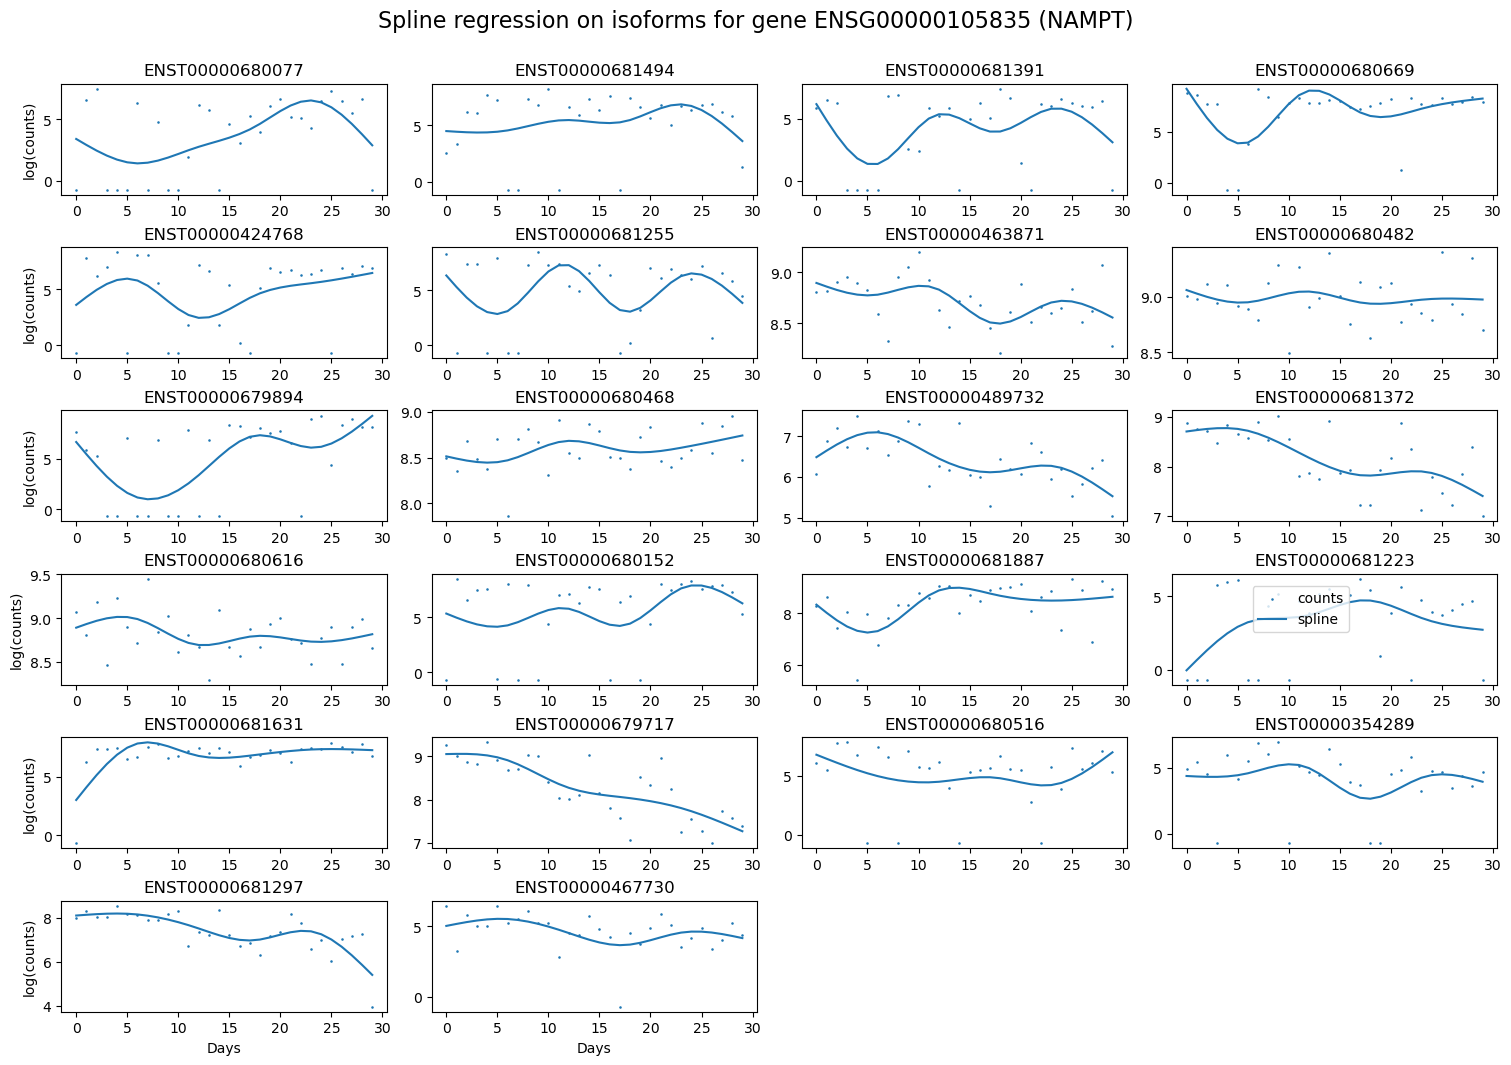

In [21]:
f = plot_genes('ENSG00000105835')

In [22]:
from matplotlib.lines import Line2D
def plot_isoforms(target_gene, ax, cmap):
    '''
    Plots the splines for all isoforms in one plot for a given gene.
    This is an auxiliary function for plot_isoform_switching().
    
    Arguments:
        target_gene (str): Gene ID in the form of ENSG...
        ax (matplotlib.axes): ax object to plot on
        cmap (str): name of colormap to use for the plots
        
    Returns:
        ax (matplotlib.axes): the plot with all isoform splines overlayed in one ax object
    '''
    targets = list(de_tx[de_tx['ens_gene']==target_gene]['target_id'])
    
    for i in range(len(targets)):
        spline = generate_plot(targets[i])[0]
        ax.plot(np.arange(30)+1, spline, label=targets[i], c=cmap(i))

    ax.set_xlabel('Days')
    ax.set_ylabel('log(normalized counts+0.5)')
    return ax

In [23]:
def calc_isoform_fractions(target_id):
    '''
    Calculates the fraction that each isoform of a given gene contributes to the gene's total expression.
    
    Arguments:
        target_id (str): gene ID in the form of ENSG...
    
    Returns:
        iso_frac (pd.DataFrame): dataframe with each isoform as a row and each column as time point
    '''
    targets = list(de_tx[de_tx['ens_gene']==target_id]['target_id'])
    tpms = tpm.loc[targets]
    iso_frac = tpms.div(tpms.sum(axis=0)).fillna(0.0)
    return iso_frac

In [24]:
def plot_isoform_fractions(target_id, ax, cmap):
    '''
    Plots the isoform fractions for all isoforms of a given gene, using the fractions from calc_isoform_fractions().
    This is an auxiliary function for plot_isoform_switching().
    Arguments:
        target_id (str): gene ID to be passed into calc_isoform_fractions(), in the form of ENSG...
        ax (matplotlib.axes): ax object to plot on
        cmap (str): name of colormap to use for the plots
    
    Returns:
        ax (matplotlib.axes): the plot with all isoform fractions for all time points, plotted as stacked bar charts 
    '''
    iso_frac = calc_isoform_fractions(target_id)
    iso_frac.columns = np.arange(30)+1
    bottom = np.zeros(iso_frac.shape[1])  # Track bottom position for stacking
    for i in range(iso_frac.shape[0]):
        ax.bar(iso_frac.columns, iso_frac.iloc[i], bottom=bottom, color=cmap(i))
        bottom += iso_frac.iloc[i]  # Update bottom for stacking
    ax.set_xlabel("Days")
    ax.set_ylabel("Isoform Fractions")
    return ax

In [25]:
def plot_gene_agg_ax(target_gene, ax):
    
    '''
    Plots the TPM-aggregated gene-level expression for a given gene and vaccination condition.
    
    Arguments:
        target_gene (str): gene ID to plot the expression for, in the form of ENSG...
        ax (matplotlib.axes): ax object to plot on 
        mode (str): vaccination condition, given by either 'pre' or 'post'
        
    Returns:
        ax (matplotlib.axes): the plot with gene-level expression from aggregated isoform expression levels
    '''
    targets = list(de_tx[de_tx['ens_gene']==target_gene]['target_id'])
    x = list(range(30))
    
    tpms = tpm.loc[targets]
    tpms = tpms.sum(axis=0)
    
    plt.plot(x, tpms)
    plt.xlabel('Days')
    plt.ylabel('Summed Normalized Counts (tpm)')
    return ax

In [26]:
def plot_isoform_switching(target_gene):
    '''
    Plots the TPM-aggregated gene-level expression for a given gene.
    
    Arguments:
        target_gene (str): gene ID to plot the expression for, in the form of ENSG...
        ax (matplotlib.axes): ax object to plot on 
        mode (str): vaccination condition, given by either 'pre' or 'post'
        
    Returns:
        ax (matplotlib.axes): the plot with gene-level expression from aggregated isoform expression levels
    '''
    targets = list(de_tx[de_tx['ens_gene']==target_gene]['target_id'])
    cmap = plt.get_cmap('Paired', len(targets))
    fig = plt.figure(layout='constrained', figsize=(13, 7))
    
    ax_dict = fig.subplot_mosaic(
        [
            ["splines", "splines"],
            ["frac", "sum"],
        ],
    )
    plot_gene_agg_ax(target_gene, ax_dict['sum'])
    plot_isoforms(target_gene, ax_dict['splines'], cmap)
    handles, labels = ax_dict['splines'].get_legend_handles_labels()
    plot_isoform_fractions(target_gene, ax_dict['frac'], cmap)
    fig.legend(handles, labels, loc='outside center right')
    ext_gene_name = de[de['target_id']==target_gene]['ext_gene'].iloc[0]
    fig.suptitle(f'Isoform Switching for {ext_gene_name}')
    return fig

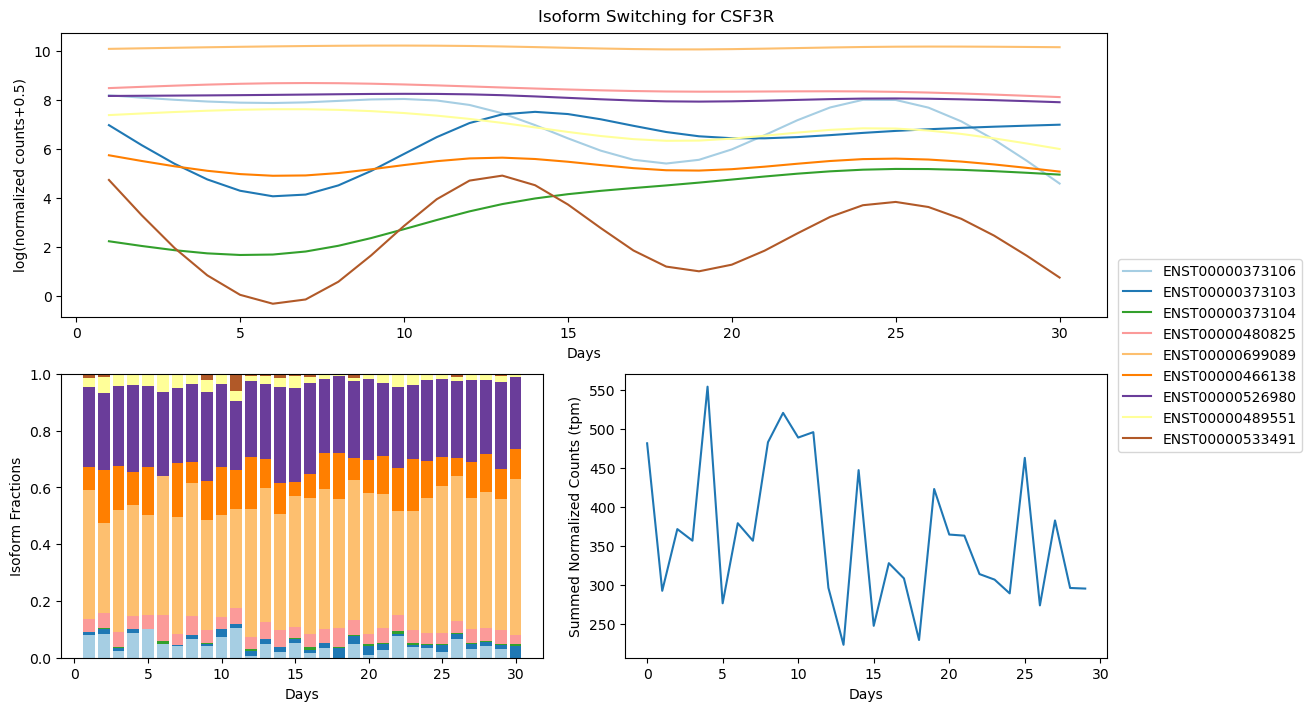

In [27]:
f = plot_isoform_switching('ENSG00000119535')
#f.savefig('plat_isoform_switching.png', dpi=300)

## Calculating R2 values

In [28]:
df5_r2_dict = {}
top_genes = de['target_id'].tolist()

for gene in top_genes:
    targets = list(de_tx[de_tx['ens_gene']==gene]['target_id'])
    r2s = []
    for target in targets:
        est, counts = generate_plot(target)
        r2 = r2_score(counts, est)
        r2s.append(r2)
    df5_r2_dict[gene] = np.mean(r2s)

r2_ls = list(df5_r2_dict.values())

In [29]:
np.mean(r2_ls)

np.float64(0.47595328872170656)